# Temporal Fusion Transformer (TFT)

## Why We Chose Temporal Fusion Transformer (TFT)

Our exploratory data analysis revealed several important characteristics in the Bitcoin fee series that guided our model choice:

### Key Observations from EDA
- **Strong temporal patterns**: Clear intraday cycles and short-term dependencies in fee fluctuations.
- **Volatility and sharp spikes**: Frequent, irregular surges in transaction fees make point estimation challenging.
- **Multivariate dependencies**: Fee dynamics are influenced by multiple time-varying factors with non-linear interactions.
- **Lagged effects**: Historical values of both the target and covariates impact future behavior.

### Why TFT is a Good Fit
- **Multi-horizon forecasting**: Captures both short-term spikes and longer trends in one pass.
- **Attention mechanism**: Learns which time steps and variables are most relevant at each point.
- **Static + time-varying input support**: Integrates contextual and real-time signals effectively.
- **Quantile-based loss**: Provides uncertainty-aware forecasts, especially valuable under volatile market conditions.
- **Interpretable outputs**: Offers insights into feature importance and temporal relevance.

> Given these insights, TFT stands out as a model capable of handling the complexity, volatility, and interpretability needs revealed through EDA.

> All commented code will be ran at `root/scripts/advanced_tft.py`. Please refer to Readme.md


##  Import

In [1]:
import pandas as pd
import torch
from torch.utils.data import DataLoader
import lightning.pytorch as pl
from lightning.pytorch import Trainer
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from torch import Tensor
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import QuantileLoss, MultiHorizonMetric
from sklearn.preprocessing import StandardScaler
from pytorch_forecasting.metrics import MAPE, MAE, RMSE
import torch.nn as nn
import numpy as np
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
import torch.nn.functional as F
import matplotlib.pyplot as plt
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim import AdamW
from lightning.pytorch.tuner import Tuner

import os
import sys
from pathlib import Path
import pickle

# Add ../src to the Python module search path
src_path = Path("..") / "src"
sys.path.append(str(src_path.resolve()))

torch.set_float32_matmul_precision('high')

## Step 1: Prepare Raw Data for Temporal Fusion Transformer (TFT)

In this step, we transform the raw Bitcoin mempool and fee dataset into a clean, long-format structure optimized for TFT. This involves:
- Removing noise and irrelevant features
- Resampling at 15-minute intervals for uniform time steps
- Assigning one row per (`series_id`, timestamp) pair (long format)
- Engineering cyclical features to capture time-of-day, day-of-week, and month effects
- Applying log transforms to skewed histogram features
- Adding lagged values to enable autoregressive learning

Proper preprocessing ensures TFT can effectively learn temporal dynamics without risk of data leakage or misalignment.


In [2]:
# Import custom preprocessing function to clean and structure raw input
from preprocess_raw_parquet import preprocess_raw_parquet

# Load and clean raw dataset from Parquet file
df = preprocess_raw_parquet("../data/raw/mar_5_may_12.parquet")  # Outputs uniform 15-min time series
df = df.iloc[:-96]
df.tail()

,mempool_blocks_blockSize,mempool_blocks_blockVSize,mempool_blocks_nTx,mempool_blocks_totalFees,mempool_blocks_medianFee,recommended_fee_fastestFee,recommended_fee_halfHourFee,recommended_fee_hourFee,recommended_fee_economyFee,recommended_fee_minimumFee,...,mempool_fee_histogram_bin_70_75,mempool_fee_histogram_bin_75_80,mempool_fee_histogram_bin_80_85,mempool_fee_histogram_bin_85_90,mempool_fee_histogram_bin_90_95,mempool_fee_histogram_bin_95_100,mempool_fee_histogram_bin_100_150,mempool_fee_histogram_bin_150_200,mempool_fee_histogram_bin_200_250,mempool_fee_histogram_bin_250_300
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-05-11 18:45:00,7.225843e+05,470774.833333,1282.333333,1.334593e+06,0.580391,1.333333,1.000000,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-05-11 19:00:00,3.872140e+05,240659.750000,819.666667,6.658160e+05,0.000000,1.000000,1.000000,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-05-11 19:15:00,1.479687e+06,917250.833333,2951.000000,2.899317e+06,2.102116,2.333333,1.000000,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-05-11 19:30:00,1.600430e+06,997964.500000,3674.333333,5.290451e+06,3.045255,4.000000,2.000000,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-05-11 19:45:00,1.577521e+06,997990.250000,3736.666667,5.244567e+06,3.251342,4.000000,2.666667,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
# Add time encodings, reshape to long format, and assign time_idx
from transform_fee_data_dl import transform_fee_data_dl
df = transform_fee_data_dl(df)

# Print column names to verify added features
print(df.columns.tolist())

['timestamp', 'series_id', 'target', 'mempool_blocks_blockSize', 'mempool_blocks_blockVSize', 'mempool_blocks_nTx', 'mempool_blocks_totalFees', 'mempool_blocks_medianFee', 'mempool_count', 'mempool_vsize', 'mempool_total_fee', 'difficulty_adjustment_progressPercent', 'difficulty_adjustment_difficultyChange', 'difficulty_adjustment_remainingBlocks', 'difficulty_adjustment_remainingTime', 'difficulty_adjustment_previousTime', 'difficulty_adjustment_nextRetargetHeight', 'difficulty_adjustment_timeAvg', 'difficulty_adjustment_adjustedTimeAvg', 'difficulty_adjustment_timeOffset', 'difficulty_adjustment_expectedBlocks', 'price_USD', 'mempool_fee_histogram_bin_1_2', 'mempool_fee_histogram_bin_2_3', 'mempool_fee_histogram_bin_3_4', 'mempool_fee_histogram_bin_4_5', 'mempool_fee_histogram_bin_5_6', 'mempool_fee_histogram_bin_6_7', 'mempool_fee_histogram_bin_7_8', 'mempool_fee_histogram_bin_8_9', 'mempool_fee_histogram_bin_9_10', 'mempool_fee_histogram_bin_10_12', 'mempool_fee_histogram_bin_12_14

In [4]:
# Add lag features (past values) for autoregressive modeling
from add_lag_features import add_lag_features

# Define columns to exclude from lagging
exclude_cols = [
    'timestamp', 'series_id', 'time_idx',
    'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos',
    'month_sin', 'month_cos', 'minute_sin', 'minute_cos'
]

# Add lag features for all numeric inputs (excluding cyclic and ID columns)
for col in df.columns:
    if (
        col not in exclude_cols
        and not col.startswith("mempool_fee_histogram_bin")
    ):
        df = add_lag_features(df, col, lag_step=96)  # Use past 1-day window for lag features

# Print column names to verify added features
print(df.columns.tolist())

['timestamp', 'series_id', 'target', 'mempool_blocks_blockSize', 'mempool_blocks_blockVSize', 'mempool_blocks_nTx', 'mempool_blocks_totalFees', 'mempool_blocks_medianFee', 'mempool_count', 'mempool_vsize', 'mempool_total_fee', 'difficulty_adjustment_progressPercent', 'difficulty_adjustment_difficultyChange', 'difficulty_adjustment_remainingBlocks', 'difficulty_adjustment_remainingTime', 'difficulty_adjustment_previousTime', 'difficulty_adjustment_nextRetargetHeight', 'difficulty_adjustment_timeAvg', 'difficulty_adjustment_adjustedTimeAvg', 'difficulty_adjustment_timeOffset', 'difficulty_adjustment_expectedBlocks', 'price_USD', 'mempool_fee_histogram_bin_1_2', 'mempool_fee_histogram_bin_2_3', 'mempool_fee_histogram_bin_3_4', 'mempool_fee_histogram_bin_4_5', 'mempool_fee_histogram_bin_5_6', 'mempool_fee_histogram_bin_6_7', 'mempool_fee_histogram_bin_7_8', 'mempool_fee_histogram_bin_8_9', 'mempool_fee_histogram_bin_9_10', 'mempool_fee_histogram_bin_10_12', 'mempool_fee_histogram_bin_12_14

In [5]:
# Define key modeling parameters
FREQ = "15min"        # Time resolution of the data
ENC_LEN = 672         # Encoder length: 7 days = 672 × 15min
PRED_STEPS = 96       # Prediction length: 1 day = 96 × 15min
BATCH_SIZE = 32       # Batch size for training
NUM_WORKERS = 4       # Number of workers for data loading

In [6]:
# Split data into train/validation sets and normalize
from split_series import split_series
from scale_series import scale_series

# Set cutoff to reserve final day for testing and day before that for validation
last_idx = df.time_idx.max() - PRED_STEPS
training_cutoff = last_idx - PRED_STEPS

# Split and standardize the features
df_train, df_valid = split_series(df, PRED_STEPS=96)
df_train, df_valid, scaler = scale_series(df_train, df_valid)

# View training set structure
df_train.head()

,timestamp,series_id,target,mempool_blocks_blockSize,mempool_blocks_blockVSize,mempool_blocks_nTx,mempool_blocks_totalFees,mempool_blocks_medianFee,mempool_count,mempool_vsize,...,difficulty_adjustment_difficultyChange_lag_96,difficulty_adjustment_remainingBlocks_lag_96,difficulty_adjustment_remainingTime_lag_96,difficulty_adjustment_previousTime_lag_96,difficulty_adjustment_nextRetargetHeight_lag_96,difficulty_adjustment_timeAvg_lag_96,difficulty_adjustment_adjustedTimeAvg_lag_96,difficulty_adjustment_timeOffset_lag_96,difficulty_adjustment_expectedBlocks_lag_96,price_USD_lag_96
0,2025-03-05 02:00:00,recommended_fee_economyFee,2.000000,1.718776,0.315714,-1.946223,-0.714628,-0.480730,-0.409374,2.866116,...,0.131665,0.010834,0.026676,0.27719,0.294297,-0.177621,-0.179539,0.0,-0.023812,-0.352336
1,2025-03-05 02:15:00,recommended_fee_economyFee,2.666667,0.592171,0.315926,-0.147425,-0.204269,-0.091919,-0.195878,2.980191,...,0.131665,0.010834,0.026676,0.27719,0.294297,-0.177621,-0.179539,0.0,-0.023812,-0.352336
2,2025-03-05 02:30:00,recommended_fee_economyFee,2.000000,1.366235,0.316204,-1.819699,-0.711815,-0.462252,-0.385740,2.971472,...,0.131665,0.010834,0.026676,0.27719,0.294297,-0.177621,-0.179539,0.0,-0.023812,-0.352336
3,2025-03-05 02:45:00,recommended_fee_economyFee,2.333333,1.218178,0.316233,-1.452224,-0.609854,-0.402567,-0.311556,3.075400,...,0.131665,0.010834,0.026676,0.27719,0.294297,-0.177621,-0.179539,0.0,-0.023812,-0.352336
4,2025-03-05 03:00:00,recommended_fee_economyFee,3.000000,0.507187,0.316165,-0.050980,-0.186345,-0.094006,-0.054725,3.155711,...,0.131665,0.010834,0.026676,0.27719,0.294297,-0.177621,-0.179539,0.0,-0.023812,-0.352336


### Why This Step Is Crucial for TFT
- Maintains causality: Ensures predictions are only based on past data.
- Supports encoder-decoder structure: Enables sliding-window learning design.
- Avoids information leakage: Keeps future targets out of the training process.
- Facilitates robust validation: Mimics real deployment conditions using temporal hold-out.
These steps ensure that the TFT model can learn meaningful patterns in fee dynamics and generalize well to future unseen time windows.

## 2: Construct TFT-Compatible Datasets (Training & Validation)

This step prepares the data loaders used for training and validating the Temporal Fusion Transformer (TFT) model.  
We explicitly define **which covariates are known at prediction time** (e.g., calendar features, lagged values) versus those that are **unknown** (e.g., real-time mempool, difficulty, and price data).

Proper dataset construction ensures:
- No future information leaks into the training process
- TFT receives clear signal from autoregressive (lagged) and temporal feature
- Overlapping windows are handled with correct alignment between encoder and decoder
- Targets are normalized per series to ensure stable optimization

---

### Why This Step?

TFT is a **sequence-to-sequence attention-based model** that depends heavily on structured temporal data. It requires:
- Separation of **known** vs. **unknown** features
- Differentiation between **static**, **time-varying known**, and **time-varying unknown** inputs
- **Sliding-window training** using teacher forcing
- Built-in **target normalization** and encoder padding

Creating a `TimeSeriesDataSet` handles all of these requirements seamlessly — preparing your data for training, validation, and prediction with minimal manual work.

---

### Dataset Composition

| Component                     | Description                                                                 |
|------------------------------|-----------------------------------------------------------------------------|
| `target`                     | The variable to forecast (e.g., `recommended_fee_fastestFee`)              |
| `group_ids`                  | Time series identifier (e.g., `series_id`)                                 |
| `real_covs`                  | Dynamic real-valued signals from mempool, difficulty, and BTC price        |
| `time_varying_known_reals`   | Features known ahead of time (e.g., calendar time + lagged covariates)     |
| `time_varying_unknown_reals` | Features not known at prediction time (e.g., target, current mempool state)|
| `target_normalizer`          | Normalizes target values per series using `GroupNormalizer`                |
| Other features               | Relative time index, encoder length, and target statistics are auto-added |

---

This structure ensures that your input data aligns with TFT’s architecture, enabling effective multi-horizon learning on Bitcoin transaction fee dynamics.


In [7]:
# Identify real-valued features from key sources
real_covs = [
    c for c in df_train.columns if c.startswith(("mempool", "difficulty", "price"))
]

# Lagged features are considered "known" at prediction time
known_lagged_covs = [
    c
    for c in df_train.columns
    if (
        "_lag_" in c
        and (
            c.startswith("mempool_")
            or c.startswith("difficulty_")
            or c.startswith("price_")
            or c.startswith("target")
        )
    )
]

# Unlagged real-valued features are "unknown" at prediction time
unknown_real_covs = [c for c in real_covs if c not in known_lagged_covs]

# Create training dataset with appropriate feature definitions
train_ds = TimeSeriesDataSet(
    df_train,
    time_idx="time_idx",  # Required time index
    target="target",  # Target variable (e.g., recommended_fee_fastest)
    group_ids=["series_id"],  # Unique series per fee type
    min_encoder_length=ENC_LEN // 2,  # For variable-length sequences
    max_encoder_length=ENC_LEN,  # Full encoder context: 7 days
    min_prediction_length=1,
    max_prediction_length=PRED_STEPS,  # Forecast 1 day ahead (96 steps)
    # Static (non-changing) categorical features, such as series ID
    static_categoricals=["series_id"],
    # Known inputs at forecast time — calendar and lagged values
    time_varying_known_reals=[
        "time_idx",
        "hour_sin",
        "hour_cos",
        "day_of_week_sin",
        "day_of_week_cos",
        "month_sin",
        "month_cos",
        "minute_sin",
        "minute_cos",
    ]
    + known_lagged_covs,
    # Unknown inputs
    time_varying_unknown_reals=["target"] + unknown_real_covs,
    # Normalize target independently per time series
    target_normalizer=GroupNormalizer(groups=["series_id"]),
    # Add helper features for better learning
    add_relative_time_idx=True,  # Adds relative time indices (0...N)
    add_target_scales=True,  # Adds per-series target mean and std
    add_encoder_length=True,  # Adds actual encoder length (for padding)
)

# Validation set: replicate structure from training set
val_ds = TimeSeriesDataSet.from_dataset(
    train_ds,
    df_valid,
    predict=True,
    stop_randomization=True,  # Always use deterministic windows for eval
)

# Convert to PyTorch DataLoaders for training and validation
num_workers = min(4, os.cpu_count())

train_dl = train_ds.to_dataloader(
    train=True, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers
)

val_dl = val_ds.to_dataloader(
    train=False,
    batch_size=BATCH_SIZE * 10,  # Larger batch size for evaluation
    shuffle=False,
    num_workers=num_workers,
)


### Why This Step Matters
- Explicit feature categorization ensures the model doesn’t cheat by accessing future data
- Lagged and cyclical inputs allow learning complex temporal dependencies
- Consistent normalizers ensure targets are scaled per-series, reducing training variance
- Encapsulation via TimeSeriesDataSet simplifies batch preparation, prediction slicing, and inference

This design prepares your Bitcoin fee time series for multi-horizon forecasting in a reliable, interpretable, and leak-free manner.

## 3: Custom Loss — MAE with Standard Deviation and Deviation Penalties

In highly volatile time series like Bitcoin transaction fees, capturing **not just the mean**, but also the **variance** and **shape** of the signal is critical.  
A model trained purely with MAE might predict smooth outputs that minimize average error but completely miss spikes — which are crucial for users estimating fee costs.

To address this, we use a custom loss function: `MAEWithStdPenalty`.

---

### Why Use `MAEWithStdPenalty`?

This loss improves over traditional MAE by adding two structure-aware penalties:

1. **Standard deviation penalty**  
   Encourages the predicted variance to match the target’s variance — helping the model learn realistic volatility.
   
2. **Deviation shape penalty**  
   Encourages the model to align the **shape** of the predicted curve with the target curve — ensuring spikes and valleys are in the right place.

Together with MAE, these ensure the model learns accurate and expressive predictions.

---

### Component Breakdown

| Component         | Description |
|------------------|-------------|
| **Base MAE**     | `y_pred - target` — captures point error |
| **Std Penalty**  | `std(y_pred) - std(target)` — penalizes incorrect volatility |
| **Deviation Penalty** | `(y_pred - mean) - (target - mean)` — penalizes mismatched curve shape |
| **Weighted Terms** | Penalties are scaled by how poorly the model performs, with optional clipping to avoid instability |


Final loss:
total_loss = base_loss  + std_weight × w_std × std_penalty + de_weight × w_dev × dev_error

---

### Example

Ground Truth: y_true = [1.0, 2.0, 3.0]

Model A: y_pred_a = [0.0, 2.0, 4.0] ← Over/under-predicts symmetrically (mirrors extremes)

Model B: y_pred_b = [2.0, 2.0, 2.0] ← Predicts flat mean (smooths out dynamics)

Now evaluate them on all loss components:

| Model | MAE  | STDdiff | DevErr | MAE + STD + Dev |
|-------|------|---------|--------|------------------|
| **A** | 0.67 | 0.00    | 1.33   | **2.0**         |
| **B** | 0.67 | 0.82    | 0.67   | **2.16**         |

Model A gets the spread (STDdiff = 0) but flips the structure (high DevErr).

Model B captures the mean, but smooths out the dynamics (high STDdiff, moderate DevErr).

But in total we prefer model A because A has a better prediction power, it capture the trend correctly.

---

### Benefits for Fee Forecasting

| Challenge                     | How the Loss Solves It |
|------------------------------|------------------------|
| Smooth predictions that ignore volatility | Std penalty enforces realistic variation |
| Spikes/dips underpredicted   | Deviation penalty reinforces structural fidelity |
| Mean-only training misleads  | MAE is enhanced by distributional constraints |
| Volatile fee environment     | Handles high variance with stability controls |

---

By incorporating this composite loss, our model learns **not just what the fee should be**, but also **how it behaves over time**, which is essential for users and applications that depend on accurate fee forecasting.



In [8]:
class MAEWithStdPenalty(MultiHorizonMetric):
    def __init__(
        self,
        std_weight=1.0,
        de_weight=1.0,
        clip_weight_std=None,
        clip_weight_dev=None,
        reduction="mean",
        **kwargs
    ):
        """
        Custom loss combining Mean Absolute Error (MAE) with std and deviation shape penalties.

        Parameters:
        std_weight (float): Weight for std deviation penalty.
        de_weight (float): Weight for deviation error penalty.
        clip_weight_std (float or None): Max clip value for std penalty weight.
        clip_weight_dev (float or None): Max clip value for deviation penalty weight.
        reduction (str): 'mean', 'sum', or 'none'.
        """
        super().__init__(reduction=reduction, **kwargs)
        self.std_weight = std_weight
        self.de_weight = de_weight
        self.clip_weight_std = clip_weight_std
        self.clip_weight_dev = clip_weight_dev

    def loss(self, y_pred: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        y_pred_point = self.to_prediction(y_pred)  # shape (B, T)

        # Base MAE
        base_loss = torch.abs(y_pred_point - target)  # (B, T)
        mae = base_loss.mean(dim=1, keepdim=True)  # (B, 1)

        # Std penalty
        pred_std = torch.std(y_pred_point, dim=1, keepdim=True)  # (B, 1)
        true_std = torch.std(target, dim=1, keepdim=True)  # (B, 1)
        std_penalty = torch.abs(pred_std - true_std)  # (B, 1)

        w_std = mae / (std_penalty + 1e-8)  # (B, 1)
        if self.clip_weight_std is not None:
            w_std = w_std.clamp(max=self.clip_weight_std)

        # Deviation penalty
        pred_mean = y_pred_point.mean(dim=1, keepdim=True)  # (B, 1)
        true_mean = target.mean(dim=1, keepdim=True)  # (B, 1)
        pred_dev = y_pred_point - pred_mean  # (B, T)
        true_dev = target - true_mean
        dev_error = torch.abs(pred_dev - true_dev)  # (B, T)

        w_dev = base_loss / (dev_error + 1e-8)  # shape (B, T)

        if self.clip_weight_dev is not None:
            w_dev = w_dev.clamp(max=self.clip_weight_dev)

        # Final loss
        total_loss = (
            base_loss
            + self.std_weight * w_std * std_penalty
            + self.de_weight * w_dev * dev_error
        )

        return total_loss


loss_fn = MAEWithStdPenalty()


## 4. Prototype Temporal Fusion Transformer and Explore Learning Rate

Before committing to a full model definition and training schedule, we can **optionally prototype** the Temporal Fusion Transformer (TFT) and run a quick learning rate sweep. This helps assess whether our data pipeline is working and gives an estimate for a stable learning rate range.


### Why This Step?

- Quickly validate that your `TimeSeriesDataSet` and `DataLoader` objects are compatible with TFT.
- Use `lr_find()` to get a **suggested learning rate** for better training stability.
- Explore model capacity (e.g., number of parameters) without running full training.


In [9]:
# # Set global random seed for reproducibility
# pl.seed_everything(42)

# # Minimal trainer with gradient clipping (important for LSTM stability)
# trainer = pl.Trainer(
#     accelerator="gpu",
#     gradient_clip_val=0.1,
# )

# # Provisional TFT configuration — useful for debugging or learning rate tuning
# tft = TemporalFusionTransformer.from_dataset(
#     train_ds,
#     learning_rate=1e-4,
#     hidden_size=32,
#     hidden_continuous_size=8,
#     lstm_layers=2,
#     dropout=0.2,
#     loss=loss_fn,
#     output_size=1,
#     weight_decay=1e-4,
#     reduce_on_plateau_patience=0,
# )

# # Check model size
# print(f"Number of parameters in network: {tft.size() / 1e3:.1f}k")

In [10]:
# from lightning.pytorch.tuner import Tuner

# res = Tuner(trainer).lr_find(
#     tft,
#     train_dataloaders=train_dl,
#     val_dataloaders=val_dl,
#     max_lr=10.0,
#     min_lr=1e-6,
#     num_training=300
# )

# # Print suggested learning rate (can be slightly underestimated due to the nature of this tuner)
# print(f"suggested learning rate: {res.suggestion()}")


In [11]:
# fig = res.plot(show=True, suggest=True)
# fig.show()

### Why This Is Helpful (But Optional)

- Allows early **debugging** of model architecture and data pipeline
- Identifies a **safe learning rate** range without committing to full training
- Can be skipped or deferred until after full feature engineering and hyperparameter tuning

You can revisit or overwrite this configuration later with your final model and trainer setup.

---

## 5. Model, Callbacks, Trainer, and Optimizer Customization

In this section, we finalize our TFT model setup and training configuration, including:

1. **Model definition** with custom loss  
2. **Callback setup** for early stopping, checkpointing, and LR logging  
3. **Trainer configuration** with mixed precision, gradient clipping, and validation schedule  
4. **Custom optimizer and scheduler** bound to the TFT instance

### 5.1 Instantiate Final TFT Model
**Why this step is important:**  
This step defines the actual architecture used for training. It includes the number of LSTM layers, hidden sizes, dropout, and the choice of loss function — all of which determine the model’s capacity, regularization, and optimization objective.

In [12]:
# # Instantiate Temporal Fusion Transformer model
# tft = TemporalFusionTransformer.from_dataset(
#     train_ds,
#     learning_rate=res.suggestion(),  # Initial learning rate
#     hidden_size=32,  # Size of LSTM and attention layers
#     hidden_continuous_size=8,  # Internal size for continuous variables, should be <= hidden size
#     lstm_layers=2,  # Number of LSTM layers (recommended 2 by pytorch document)
#     dropout=0.2,  # Dropout for regularization (recommended 0.1-0.3 by pytorch document)
#     loss=MAEWithDynamicStdAndDeviationPenalty(beta=1.0, clip_weight=10.0),  # Quantile regression loss
#     output_size=1,  # One output per quantile
#     weight_decay=1e-4,  # L2 regularization strength
#     reduce_on_plateau_patience=0,  # Disable internal LR scheduling, we will use our own optimiser
# )

### 5.2 Set Up Callbacks

**Why this step is important:**  
Callbacks automate critical training events such as saving the best model, stopping early to prevent overfitting, and tracking learning rate schedules — saving time and avoiding manual errors.


In [13]:

# callbacks = [
#     EarlyStopping(
#         monitor="val_loss",  # Watch validation loss for improvements
#         patience=15,  # Stop training if no improvement for 15 validation checks
#         min_delta=0.003,  # Minimum change in val_loss to qualify as improvement
#         mode="min",  # Lower val_loss is better
#         verbose=True,  # Print early stopping messages
#     ),
#     LearningRateMonitor(),  # Log learning rate at each step (helps with debugging/tracking)
#     ModelCheckpoint(
#         dirpath="../results/models",  # Folder to save model checkpoints
#         filename="best-model-{epoch}-{val_loss:.4f}",  # File naming format
#         monitor="val_loss",  # Save the model with the lowest val_loss
#         save_top_k=1,  # Keep only the best model
#         mode="min",  # Lower val_loss is better
#         save_last=True,  # Also save the final model from the last epoch
#         verbose=True,  # Print checkpoint saving messages
#     ),
# ]

- **EarlyStopping**: Stops training when validation loss plateaus for 15 checks.
- **LearningRateMonitor**: Logs learning rate for better visibility.
- **ModelCheckpoint**: Saves best and last models by validation loss.

### 5.3 Configure the Trainer

**Why this step is important:**  
This is the engine that runs the training loop. Here, we specify whether to use GPU, how long to train, when to validate, and whether to clip gradients. These settings influence speed, stability, and resource efficiency.


In [14]:
# trainer = pl.Trainer(
#     max_epochs=100,  # Upper limit on training epochs
#     accelerator="gpu",  # Use GPU acceleration
#     devices=1,  # Use a single GPU
#     precision="bf16-mixed",  # Use mixed-precision with bfloat16 for faster training (if supported)
#     gradient_clip_val=0.5,  # Prevent exploding gradients by clipping them
#     callbacks=callbacks,  # Attach previously defined callbacks
#     accumulate_grad_batches=1,  # No gradient accumulation
#     deterministic=False,  # Allow non-deterministic ops for faster training
#     enable_progress_bar=True,  # Show training progress
#     val_check_interval=0.5,  # Run validation twice per epoch (e.g., at 50% and 100%)
# )

- **bf16-mixed precision** accelerates training on supported GPUs (e.g., A100, 4090).
- **Gradient clipping** improves stability on spiky updates.
- **Validation every half epoch** gives more frequent feedback during long training runs.

### 5.4 Bind a Custom Optimizer and Learning Rate Scheduler

**Why this step is important:**  
TFT has complex dynamics, especially with LSTM layers. A well-chosen optimizer (AdamW) and scheduler (ReduceLROnPlateau) can **stabilize training**, prevent overshooting, and adapt learning rate if performance plateaus — often improving convergence and generalization.


In [15]:
# def configure_optimizers_fix(self):
#     optimizer = AdamW(
#         self.parameters(),
#         lr=res.suggestion(),  # Starting learning rate
#         weight_decay=1e-4,  # Regularization term
#         eps=1e-6,  # Small constant for numerical stability
#     )

#     scheduler = ReduceLROnPlateau(
#         optimizer,
#         mode="min",  # Reduce LR if val_loss stops decreasing
#         factor=0.7,  # Shrink LR by 30% on plateau
#         patience=8,  # Wait for 8 epochs of no improvement
#         min_lr=1e-6,  # Set a lower bound on learning rate
#     )

#     return {
#         "optimizer": optimizer,
#         "lr_scheduler": {
#             "scheduler": scheduler,
#             "monitor": "val_loss",  # Validation loss guides learning rate updates
#             "interval": "epoch",  # Check once every epoch
#             "frequency": 1,  # Apply scheduler every epoch
#         },
#     }


# # Bind the optimizer/scheduler to the model
# tft.configure_optimizers = configure_optimizers_fix.__get__(tft, type(tft))

> This is dynamically bound to the TFT instance to override its default optimizer logic.

### Final Notes

Each step above ensures that our model:

- Is well-structured and regularized (`5.1`)
- Is safely and automatically monitored during training (`5.2`)
- Is efficiently trained using the right hardware and schedules (`5.3`)
- Learns using a flexible and adaptive optimization strategy (`5.4`)

Together, they enable a stable, traceable, and efficient training pipeline for probabilistic forecasting using Temporal Fusion Transformer.

---

## 6. Fit the model with dataloaders

In [16]:
# trainer.fit(tft, train_dl, val_dl)

## 7. Load the Best Trained Model from Checkpoint

After training, we often want to **reload the best-performing model** for prediction, fine-tuning, or evaluation. PyTorch Lightning makes this straightforward via `.load_from_checkpoint()`.

### Why This Step Is Important

- **Ensures reproducibility**: You can restore exactly what was trained and evaluated.
- **Avoids retraining**: Skip expensive training if the model has already converged.
- **Supports inference and deployment**: Load the model directly on CPU or GPU for prediction.


In [17]:
from torch.serialization import add_safe_globals
# Set the root directory of the project and add the advanced_tft scripts folder to the Python path
project_root = Path("../").resolve()
sys.path.insert(0, str(project_root / "scripts" / "advanced_tft"))

# Path to the model checkpoint file (This is the best one, use this for validation)
best_model_path = "../results/models/best-model-tft-v5.pt"
# Register TemporalFusionTransformer as a safe class for unpickling (required in PyTorch 2.6+)
add_safe_globals([TemporalFusionTransformer]) 
# Load the entire saved model (assuming it was saved using torch.save(model, path))
# Setting weights_only=False ensures the full object is deserialized
model = torch.load(best_model_path, map_location="cpu", weights_only=False)

### Notes

- The checkpoint contains both the **model weights** and **hyperparameters**, so you don’t need to redefine the architecture manually.
- You can use this model directly for forecasting using `.predict(...)`, or inspect it for further analysis.
- Make sure the `map_location` matches your device setup (e.g., `"cuda"` if using GPU).

This step completes the training lifecycle and prepares the model for downstream forecasting tasks.

---

## 8. Make Predictions with the Trained TFT Model

In this step, we use the trained Temporal Fusion Transformer to generate forecasts for the final test period. This includes:
- Constructing **encoder** and **decoder** inputs
- Zeroing out future unknowns to simulate a real-world forecast
- Running `.predict(...)` to generate quantile-based forecasts
- Structuring output into a tidy `df_eval` DataFrame for evaluation or plotting

### Why This Step Is Important

- Ensures predictions are made using **only historical and known future data** — no leakage.
- Mimics deployment conditions where future target and covariates are unavailable.
- Helps assess the **quality and uncertainty** of forecasts using quantiles (0.1, 0.5, 0.9).


In [18]:
# Select encoder input: last `ENC_LEN` time steps before prediction starts
encoder_data = df[
    lambda x: (
        (x.time_idx > x.time_idx.max() - PRED_STEPS - ENC_LEN)
        & (x.time_idx <= x.time_idx.max() - PRED_STEPS)
    )
]

# Select final known row (e.g., last day in validation period)
last_data = df[lambda x: x.time_idx == x.time_idx.max() - PRED_STEPS]

# Select decoder input: true test range (e.g., last 96 steps)
decoder_data = df[lambda x: x.time_idx > last_idx].copy()

# Save true target values for later comparison
df_true = decoder_data.copy()

# Columns to zero out (simulate unknown future inputs)
cols_to_zero = ["target"] + real_covs
decoder_data[cols_to_zero] = (
    0  # Set target and unknown reals to zero (not known in future)
)
# Concatenate encoder and decoder to form complete input for prediction
new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)
df_true = df_valid[
    lambda x: (
        (x.time_idx > x.time_idx.max() - PRED_STEPS)
        & (x.time_idx <= x.time_idx.max() )
    )
]
df_true.head()

,timestamp,series_id,target,mempool_blocks_blockSize,mempool_blocks_blockVSize,mempool_blocks_nTx,mempool_blocks_totalFees,mempool_blocks_medianFee,mempool_count,mempool_vsize,...,difficulty_adjustment_difficultyChange_lag_96,difficulty_adjustment_remainingBlocks_lag_96,difficulty_adjustment_remainingTime_lag_96,difficulty_adjustment_previousTime_lag_96,difficulty_adjustment_nextRetargetHeight_lag_96,difficulty_adjustment_timeAvg_lag_96,difficulty_adjustment_adjustedTimeAvg_lag_96,difficulty_adjustment_timeOffset_lag_96,difficulty_adjustment_expectedBlocks_lag_96,price_USD_lag_96
6408,2025-05-10 20:00:00,recommended_fee_economyFee,2.0,0.204689,0.316335,-0.676080,-0.575387,-0.360107,-0.971025,-0.835288,...,0.741665,0.162757,0.106968,1.727165,1.69503,-0.531007,-0.745536,0.0,-0.224210,2.832212
6409,2025-05-10 20:15:00,recommended_fee_economyFee,2.0,-0.018025,0.315997,0.491406,-0.130973,-0.023545,-0.787079,-0.717240,...,0.727062,0.161047,0.106476,1.727165,1.69503,-0.523817,-0.732232,0.0,-0.221638,2.845248
6410,2025-05-10 20:30:00,recommended_fee_economyFee,2.0,-0.133364,0.316343,0.562678,0.145377,0.207364,-0.651556,-0.654544,...,0.746561,0.157056,0.100973,1.727165,1.69503,-0.533461,-0.750077,0.0,-0.219068,2.833318
6411,2025-05-10 20:45:00,recommended_fee_economyFee,2.0,0.108947,0.316256,0.753281,0.045712,0.106224,-0.603747,-0.633964,...,0.774526,0.152496,0.094235,1.727165,1.69503,-0.547254,-0.775599,0.0,-0.216498,2.822493
6412,2025-05-10 21:00:00,recommended_fee_economyFee,2.0,0.200985,0.316294,-0.038883,-0.086010,0.117566,-0.670968,-0.635152,...,0.768481,0.150216,0.092486,1.727165,1.69503,-0.544305,-0.770143,0.0,-0.213931,2.815568


In [19]:
pl.seed_everything(42)

# Predict using the loaded TFT model
pred = model.predict(
    df_valid, # Since we have put target and other not known covariates into time_varying_unknown_reals. We can simply put df_valid here for prediction
    mode="raw",  # Return raw quantile outputs
    return_index=True,  # Return index values for later merging
    return_x=True,  # Return input data (x) as well
    trainer_kwargs=dict(accelerator="gpu"),  # Use GPU for faster inference
)


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\davyx\anaconda3\envs\satcast\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


In [20]:
# Shape: (batch, decoder_length)
batch, pred_len = pred.x["decoder_time_idx"].shape

# Convert raw tensor to NumPy for post-processing
y_pred = pred.output.prediction.detach().cpu().numpy().flatten()



# Combine predictions with true values and metadata
df_eval = pd.DataFrame(
    dict(
        timestamp=df_true["timestamp"],
        time_idx=df_true["time_idx"],
        series_id=df_true["series_id"],
        y_true=df_true["target"],
        y_pred=y_pred
    )
)

# Final output: ready for evaluation or visualization
df_eval.head()

,timestamp,time_idx,series_id,y_true,y_pred
6408,2025-05-10 20:00:00,6408,recommended_fee_economyFee,2.0,1.748477
6409,2025-05-10 20:15:00,6409,recommended_fee_economyFee,2.0,1.772506
6410,2025-05-10 20:30:00,6410,recommended_fee_economyFee,2.0,1.775627
6411,2025-05-10 20:45:00,6411,recommended_fee_economyFee,2.0,1.774769
6412,2025-05-10 21:00:00,6412,recommended_fee_economyFee,2.0,1.777054


In [21]:
from save_csv_data import save_csv_data  # Adjust if defined locally

# Filter rows where series_id is "recommended_fee_fastestFee"
df_filtered = df_eval[df_eval["series_id"] == "recommended_fee_fastestFee"]

# Define output path
output_path = "../results/tables/tft_results.csv" 

# Save using the utility function
save_csv_data(df_filtered, output_path, index=False)

### Summary

This step completes the forecasting pipeline:
- It uses true historical context (encoder)
- It simulates unseen future conditions (decoder)

We can now use `df_eval` for:
- Plotting forecasts vs. actuals
- Calculating metrics (e.g., custom loss)
- Visual inspection of prediction confidence bands

---

## 9. Evaluate Forecast Accuracy and Visualize Results

After generating predictions with our trained Temporal Fusion Transformer, we now:

1. **Compute evaluation metrics** like MAE, RMSE, MAPE and our custom loss per series  
2. **Visualize predicted vs. actual values** along with prediction intervals  
3. Review model performance and **assess forecast uncertainty**

### 9.1 Compute Evaluation Metrics (Per Series)

**Why this step is important:**  
Metrics help quantify how well the model is performing. Evaluating per `series_id` ensures we capture model quality across all partitions of the time series.


In [22]:
df_xgboost = pd.read_csv("../xgboost.csv")
df_filtered["y_pred"] = df_xgboost["recommended_fee_fastestFee"].values
df_filtered

C:\Users\davyx\AppData\Local\Temp\ipykernel_60792\4137051754.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["y_pred"] = df_xgboost["recommended_fee_fastestFee"].values


,timestamp,time_idx,series_id,y_true,y_pred
12912,2025-05-10 20:00:00,6408,recommended_fee_fastestFee,2.333333,2.659593
12913,2025-05-10 20:15:00,6409,recommended_fee_fastestFee,3.333333,2.585451
12914,2025-05-10 20:30:00,6410,recommended_fee_fastestFee,4.000000,2.458028
12915,2025-05-10 20:45:00,6411,recommended_fee_fastestFee,4.000000,2.560608
12916,2025-05-10 21:00:00,6412,recommended_fee_fastestFee,4.000000,2.467586
...,...,...,...,...,...
13003,2025-05-11 18:45:00,6499,recommended_fee_fastestFee,1.333333,2.411968
13004,2025-05-11 19:00:00,6500,recommended_fee_fastestFee,1.000000,2.424613
13005,2025-05-11 19:15:00,6501,recommended_fee_fastestFee,2.333333,2.393582
13006,2025-05-11 19:30:00,6502,recommended_fee_fastestFee,4.000000,2.420133


In [24]:
from mae_with_std_penalty_np import mae_with_std_penalty_np

metrics_per_sid = (
    df_eval.groupby("series_id")
    .apply(
        lambda g: pd.Series(
            {
                "MAE": np.abs(g.y_pred - g.y_true).mean(),
                "RMSE": np.sqrt(((g.y_pred - g.y_true) ** 2).mean()),
                "MAPE": (np.abs((g.y_pred - g.y_true) / g.y_true).mean() * 100),
                "Custom Loss (MAE+STD+Dev)": mae_with_std_penalty_np(
                    g.y_pred.values, g.y_true.values,
                    std_weight=1.0,
                    de_weight=1.0
                ),
            }
        )
    )
    .reset_index()
    .sort_values("RMSE")
)
metrics_per_sid

C:\Users\davyx\AppData\Local\Temp\ipykernel_60792\724662311.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


,series_id,MAE,RMSE,MAPE,Custom Loss (MAE+STD+Dev)
4,recommended_fee_minimumFee,0.006271,0.006307,0.627109,0.007452
0,recommended_fee_economyFee,0.464349,0.536575,40.192487,1.389690
3,recommended_fee_hourFee,0.650809,0.762274,46.866044,1.449231
2,recommended_fee_halfHourFee,0.639631,0.764140,37.072308,1.426154
1,recommended_fee_fastestFee,0.754219,0.942211,34.698355,1.776971


- **MAE** reflects average error in absolute terms.
- **RMSE** penalizes larger errors more heavily.
- **MAPE** is scale-independent and expresses error as a percentage.
- **Custom Loss (MAE + STD + Deviation Error)** is a composite objective function that combines:
  - **MAE**: Ensures accurate average predictions.
  - **STD penalty**: Penalizes the mismatch in standard deviation between predictions and ground truth, encouraging the model to capture the true **volatility** of the target series.
  - **Deviation shape error**: Adds a penalty based on the shape difference between the predicted and actual curves, computed via deviation from the mean. This promotes forecasts that better mirror the **temporal dynamics** and **fluctuation patterns** of the real data.

  This custom loss is especially effective in capturing not just the central trend but also the spread and structure of volatile Bitcoin fee sequences — making it suitable for multi-horizon forecasting in dynamic environments.


## 9.2 Plot Forecast Results for the First 5 Series

**Why this step is important:**  
Looking at several forecast plots helps confirm:
- If the **predicted values track the real data**
- Whether the model tends to **under- or overpredict**

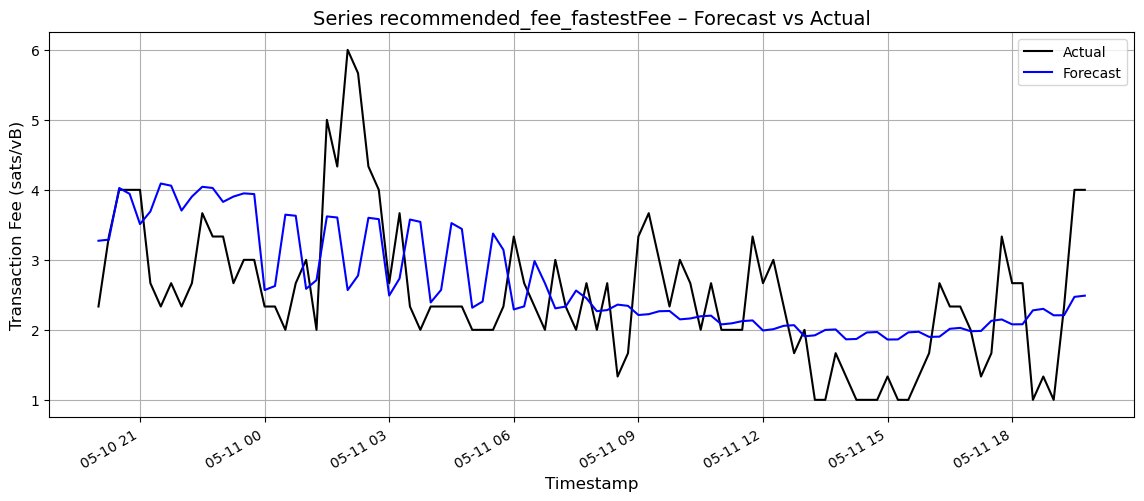

In [26]:
from plot_series import plot_series
plot_series(df_eval, sid="recommended_fee_fastestFee")
plt.show()

### Summary

This step:
- Quantifies forecasting accuracy with interpretable metrics
- Visualizes forecast sharpness, bias, and uncertainty

# Conclusion

In this notebook, we walked through the full pipeline of training and using a **Temporal Fusion Transformer (TFT)** for probabilistic Bitcoin transaction fee forecasting. Starting from raw data ingestion, preprocessing, and feature engineering, we trained the model using historical mempool data and time-varying covariates.

While TFT is capable of multi-horizon forecasting, a common challenge arises as the **prediction horizon extends further**: the model’s accuracy naturally deteriorates due to **increasing uncertainty, reduced context, and error accumulation** over time. We observed this effect in our experiments — short-term forecasts were reasonably accurate, but long-term predictions became less reliable.

To address this, incorporating richer external signals can help the model generalize better. One particularly valuable direction is to introduce **event-based features**. These include:

- **On-chain events**: large transactions, exchange inflows/outflows, whale movements  
- **Network changes**: BRC-20 surges, NFT minting waves, protocol upgrades (e.g., Taproot)  
- **Economic or geopolitical events**: regulation news, market crashes, ETF announcements  
- **Scheduled network activities**: major maintenance, forks, or miner behavior changes  
- **Social sentiment indicators**: spikes in discussion volume on crypto platforms

Such features capture **non-stationary, high-impact shocks** that raw mempool data alone cannot represent. Integrating these signals can significantly improve the model’s robustness — especially in volatile or spike-heavy fee regimes.

With this pipeline, you now have a strong foundation for adapting TFT to real-time Bitcoin fee forecasting tasks, supporting decision-making and dynamic fee estimation in production blockchain environments.